<a href="https://colab.research.google.com/github/wxya2017/GR5242-CIFAR10/blob/master/wxy_keras_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir data

In [0]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf

import keras
from keras.models import Sequential, load_model
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.datasets import cifar10
import time

In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict



def load_data(dir):
    train_x = np.array(unpickle(dir+'data_batch_1')[b'data'])
    train_y = np.array(unpickle(dir+'data_batch_1')[b'labels'])
    for i in range(2,6):
        train_x = np.concatenate((train_x, np.array(unpickle(dir+'data_batch_'+str(i))[b'data'])), axis = 0)
        train_y = np.concatenate((train_y, np.array(unpickle(dir+'data_batch_'+str(i))[b'labels'])),axis = 0)


    test_x = np.array(unpickle(dir+'test_batch')[b'data'])
    test_y = np.array(unpickle(dir+'test_batch')[b'labels'])   
    labels = unpickle(dir+'batches.meta')[b'label_names']
    return train_x, train_y, test_x, test_y, labels

In [0]:
def reshape(image):
    out = np.zeros(shape=[32,32,3])
    for i in range(3):
        out[:,:,i] = image[1024*i:1024*(i+1)].reshape([32,32])
    return out

def pre_process_x(x):
    new_x = np.zeros(shape=[len(x),32,32,3])
    for i in range(len(x)):
        new_x[i] = reshape(x[i])
    new_x = new_x/255
    return new_x

def pre_process_y(y):
    new_y = np.zeros([len(y),10])
    for i in range(len(y)):
        new_y[i][y[i]-1] = 1
    return new_y

In [4]:
ori_train_x, ori_train_y, ori_test_x, ori_test_y, labels = load_data('data/')

train_x = pre_process_x(ori_train_x)
test_x = pre_process_x(ori_test_x)
train_y = pre_process_y(ori_train_y)
test_y = pre_process_y(ori_test_y)
print("===>training data shape is "+ str(train_x.shape))
print("===>test data shape is "+ str(test_x.shape))
print("===>training label shape is "+ str(train_y.shape))
print("===>test label shape is "+ str(test_y.shape))

===>training data shape is (50000, 32, 32, 3)
===>test data shape is (10000, 32, 32, 3)
===>training label shape is (50000, 10)
===>test label shape is (10000, 10)


In [0]:
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size = 0.2, random_state = 0)

In [0]:
# Functions for plots
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2,figsize=(10, 5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'validation'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'validation'], loc='best')
    plt.show()

In [0]:
# Define the model
num_classes = 10

# kernel_regularizer=regularizers.l2(weight_decay)
model = Sequential()
model.add(Conv2D(32, (5,5), padding='same', kernel_regularizer = regularizers.l2(0.001), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer = regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer = regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (5,5), padding='same', kernel_regularizer = regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, (3,3), padding='same'))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Summarize the model
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 


In [77]:
# Train the model
start = time.time()
fit_history = model.fit(train_x, train_y,
                       batch_size=128, epochs=50,
                       validation_data = (valid_x, valid_y),
                       verbose=1)
end = time.time()

# Training time
print("Model took %0.2f seconds to train"%(end - start))

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 20s 511us/step - loss: 1.8997 - acc: 0.3453 - val_loss: 1.9435 - val_acc: 0.3890
Epoch 2/50
40000/40000 [==============================] - 17s 417us/step - loss: 1.4710 - acc: 0.5072 - val_loss: 1.3537 - val_acc: 0.5478
Epoch 3/50
40000/40000 [==============================] - 17s 423us/step - loss: 1.2806 - acc: 0.5805 - val_loss: 1.3219 - val_acc: 0.5601
Epoch 4/50
40000/40000 [==============================] - 17s 420us/step - loss: 1.1588 - acc: 0.6237 - val_loss: 1.3625 - val_acc: 0.5608
Epoch 5/50
40000/40000 [==============================] - 17s 419us/step - loss: 1.0843 - acc: 0.6553 - val_loss: 1.2720 - val_acc: 0.5843
Epoch 6/50
40000/40000 [==============================] - 17s 416us/step - loss: 1.0176 - acc: 0.6768 - val_loss: 1.3864 - val_acc: 0.5506
Epoch 7/50
40000/40000 [==============================] - 17s 425us/step - loss: 0.9720 - acc: 0.6951 - val_loss: 1.

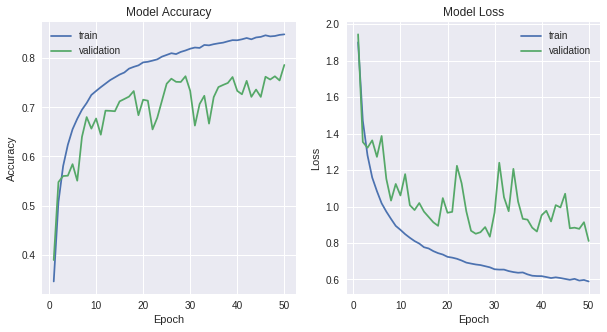

10000/10000 [==============================] - 1s 149us/step

Test result: 77.740 loss: 0.838


In [78]:
plot_model_history(fit_history)

acc = model.evaluate(test_x, test_y, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (acc[1]*100, acc[0]))

In [0]:
model.save('keras_model1.h5')

In [0]:
# del model
model = load_model('keras_model1.h5')

In [88]:
y_prob = model.predict(test_x) 
y_pred = y_prob.argmax(axis=-1)
y_pred[:5]

array([2, 7, 7, 9, 5])

In [80]:
y_true = np.where(test_y == 1)[1]
y_true[:5]

array([2, 7, 7, 9, 5])

In [89]:
cm = confusion_matrix(y_true, y_pred, labels = range(10))
cm

array([[878,   4,   3,   1,   4,   9,   2,  45,  38,  16],
       [  0, 718,  45,  45,  39,  76,  13,  16,   1,  47],
       [  1,  70, 644,  54, 121,  59,  17,   8,   3,  23],
       [  1,  70,  50, 786,  11,  29,  24,  11,   0,  18],
       [  0,  59, 155,  38, 675,  27,  29,   3,   1,  13],
       [  2,  38,  52,  22,  14, 864,   1,   3,   1,   3],
       [  2,  56,  47,  52,  44,   9, 758,   4,   5,  23],
       [  5,  13,  13,   1,   0,   6,   0, 907,   7,  48],
       [ 75,  12,  19,   2,   4,   4,   8,  60, 779,  37],
       [  8,  83,  22,   8,   5,   5,   5,  86,  13, 765]])

In [0]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(cm, index = [i for i in labels],
                     columns = [i for i in labels])

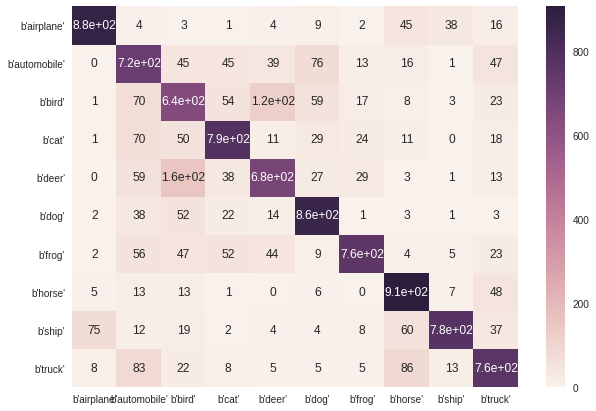

In [91]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [0]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
import numpy as np


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

baseMapNum = 32
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )
datagen.fit(x_train)

#training
batch_size = 64
epochs=25
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy',
        optimizer=opt_rms,
        metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),steps_per_epoch=x_train.shape[0] // batch_size,epochs=3*epochs,verbose=1,validation_data=(x_test,y_test))
model.save_weights('cifar10_normal_rms_ep75.h5')

opt_rms = keras.optimizers.rmsprop(lr=0.0005,decay=1e-6)
model.compile(loss='categorical_crossentropy',
        optimizer=opt_rms,
        metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,verbose=1,validation_data=(x_test,y_test))
model.save_weights('cifar10_normal_rms_ep100.h5')

opt_rms = keras.optimizers.rmsprop(lr=0.0003,decay=1e-6)
model.compile(loss='categorical_crossentropy',
        optimizer=opt_rms,
        metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,verbose=1,validation_data=(x_test,y_test))
model.save_weights('cifar10_normal_rms_ep125.h5')

#testing - no kaggle eval
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))